# Fitting a donut distribution with a normalizing flow

This notebook shows how to fit a simple, 2-dimensional probability density function using a normalizing flow.

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(f'Tensorflow version {tf.__version__}')
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow_probability as tfp
print(f'Tensorflow Probability version {tfp.__version__}')
tfb = tfp.bijectors
tfd = tfp.distributions

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import json

Tensorflow version 2.2.0
Tensorflow Probability version 0.10.0


We import `flow_tf.py`, which contains our normalizing flow implementation and several useful utility functions:

In [2]:
sys.path.append('../scripts/')
import flow_tf

Tensorflow version 2.2.0
Tensorflow Probability version 0.10.0


# Generate mock data

We draw points from a 2D distribution that we'll refer to as "the donut." In polar coordinates, we draw
$$
  r \sim \mathcal{N} \left( 1, \sigma \right) \, ,
  \\
  \theta \sim \mathcal{U} \left( 0, 2\pi \right) \, ,
$$
where $\sigma \ll 1$, so that $r > 0$. We choose $\sigma = 0.1$. The density corresponding to this distribution is
$$
  p \left( r , \theta \right) =
    \frac{1}{\left( 2 \pi \right)^{3/2} \sigma r} \,
    e^{-\frac{\left( r - 1 \right)^2}{2 \sigma^2}}
  \, .
$$

In [3]:
def sample_true(n, sigma=0.1):
    """
    Draws n samples from the donut distribution. Returns
    a tensor containing (x,y)-coordinates, with shape (n,2).
    """
    r = np.random.normal(1.0, sigma, size=n)
    theta = np.random.uniform(0., 2.*np.pi, size=n)
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    q = np.stack([x,y], axis=1).astype('f4')
    return tf.Variable(q)

def p_true(y):
    """
    Returns the true p(y) at the given points y.
    """
    r = np.sqrt(y[:,0]**2+y[:,1]**2)
    return np.exp(-0.5*((r-1.)/0.1)**2) / r

In [4]:
n_samples = 1024 * 1024
data = sample_true(n_samples)

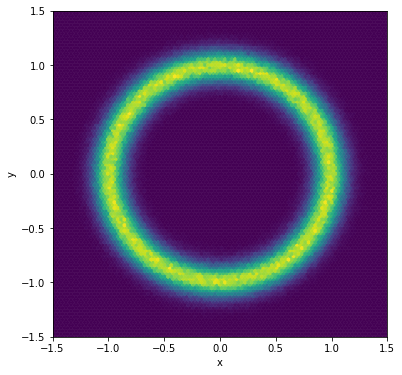

In [5]:
xlim = (-1.5, 1.5)
fig,ax = plt.subplots(1,1, figsize=(6,6))
ax.hexbin(data[:,0], data[:,1], extent=xlim+xlim, lw=0.5)
ax.set_xlim(xlim)
ax.set_ylim(xlim)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

# Train normalizing flow

We now generate and train normalizing flow on this data:

In [6]:
n_dim = 2
n_units = 8 # Number of (inv1x1conv + RQS) units to chain
flow = flow_tf.NormalizingFlow(n_dim, n_units)
callback = flow_tf.get_training_callback(
    flow,
    every=512,
    p_true_fn=p_true
)
loss_history = flow_tf.train_flow(
    flow, data,
    callback=callback
)

Tracing calc_flow_loss_gradients
Tracing calc_flow_loss_gradients
Step     1 of 32768: <loss> = 2.46846 , lr = 0.02
Step   513 of 32768: <loss> = 1.20284 , lr = 0.01795
Step  1025 of 32768: <loss> = 1.02820 , lr = 0.01611
Step  1537 of 32768: <loss> = 1.04041 , lr = 0.01446
Step  2049 of 32768: <loss> = 1.04549 , lr = 0.01298
Step  2561 of 32768: <loss> = 1.07149 , lr = 0.01166
Step  3073 of 32768: <loss> = 0.99931 , lr = 0.01046
Step  3585 of 32768: <loss> = 1.02144 , lr = 0.009393
Step  4097 of 32768: <loss> = 0.99501 , lr = 0.008432
Step  4609 of 32768: <loss> = 1.03256 , lr = 0.007569
Step  5121 of 32768: <loss> = 1.00559 , lr = 0.006795
Step  5633 of 32768: <loss> = 1.02433 , lr = 0.0061
Step  6145 of 32768: <loss> = 0.99858 , lr = 0.005476
Step  6657 of 32768: <loss> = 1.01022 , lr = 0.004915
Step  7169 of 32768: <loss> = 0.98194 , lr = 0.004413
Step  7681 of 32768: <loss> = 0.99307 , lr = 0.003961
Step  8193 of 32768: <loss> = 0.98741 , lr = 0.003556
Step  8705 of 32768: <loss> 

Save the trained normalizing flow to a JSON file:

In [7]:
with open('donut_flow.json', 'w') as f:
    json.dump(flow.serialize(), f)

It's possible to load the flow from this file later:

In [8]:
with open('donut_flow.json', 'r') as f:
    flow = flow_tf.NormalizingFlow.deserialize(json.load(f))

# Plot results

First, we plot the loss history:

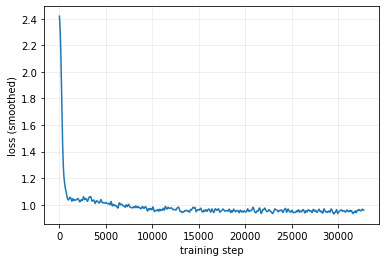

In [12]:
w = np.kaiser(250,5)
w /= np.sum(w)
loss_conv = np.hstack([
    np.repeat(loss_history[0], 125),
    np.array(loss_history),
    np.array(loss_history)[-125:][::-1]
])
loss_conv = np.convolve(loss_conv, w, mode='valid')
# loss_conv = loss_conv[5000:]
plt.plot(np.arange(len(loss_conv)), loss_conv)
plt.grid('on', alpha=0.25)
plt.ylabel('loss (smoothed)')
plt.xlabel('training step')
plt.show()

Then, we visualize the normalizing flow:

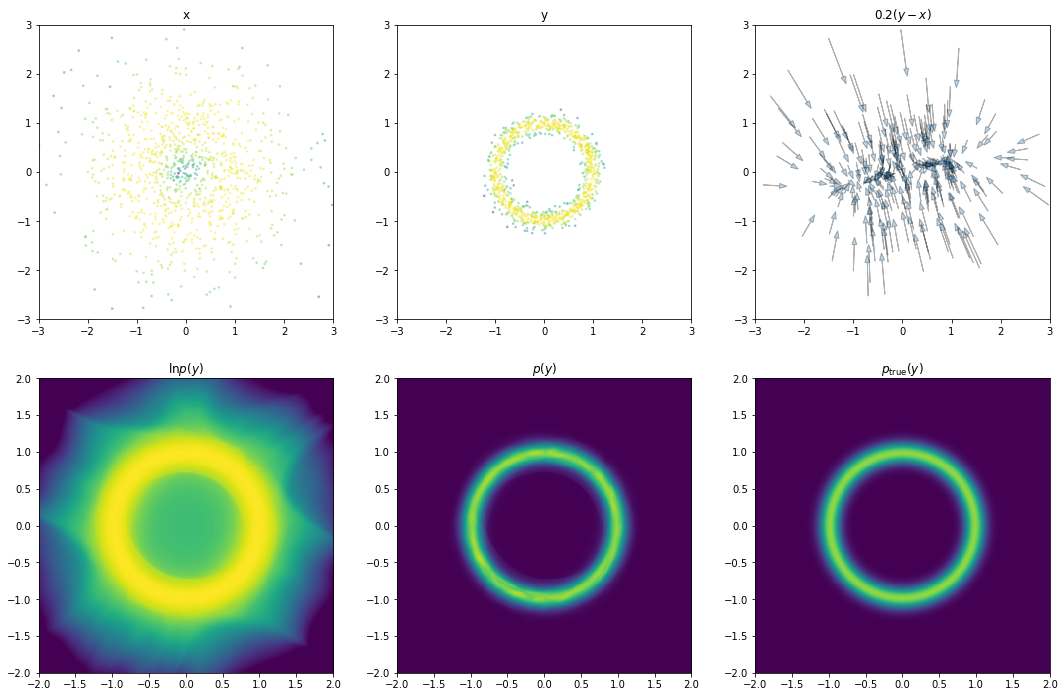

In [10]:
fig = flow_tf.get_flow_plot_fn(flow, p_true_fn=p_true)()
plt.show()

We can also visualize the bijectors in the flow:

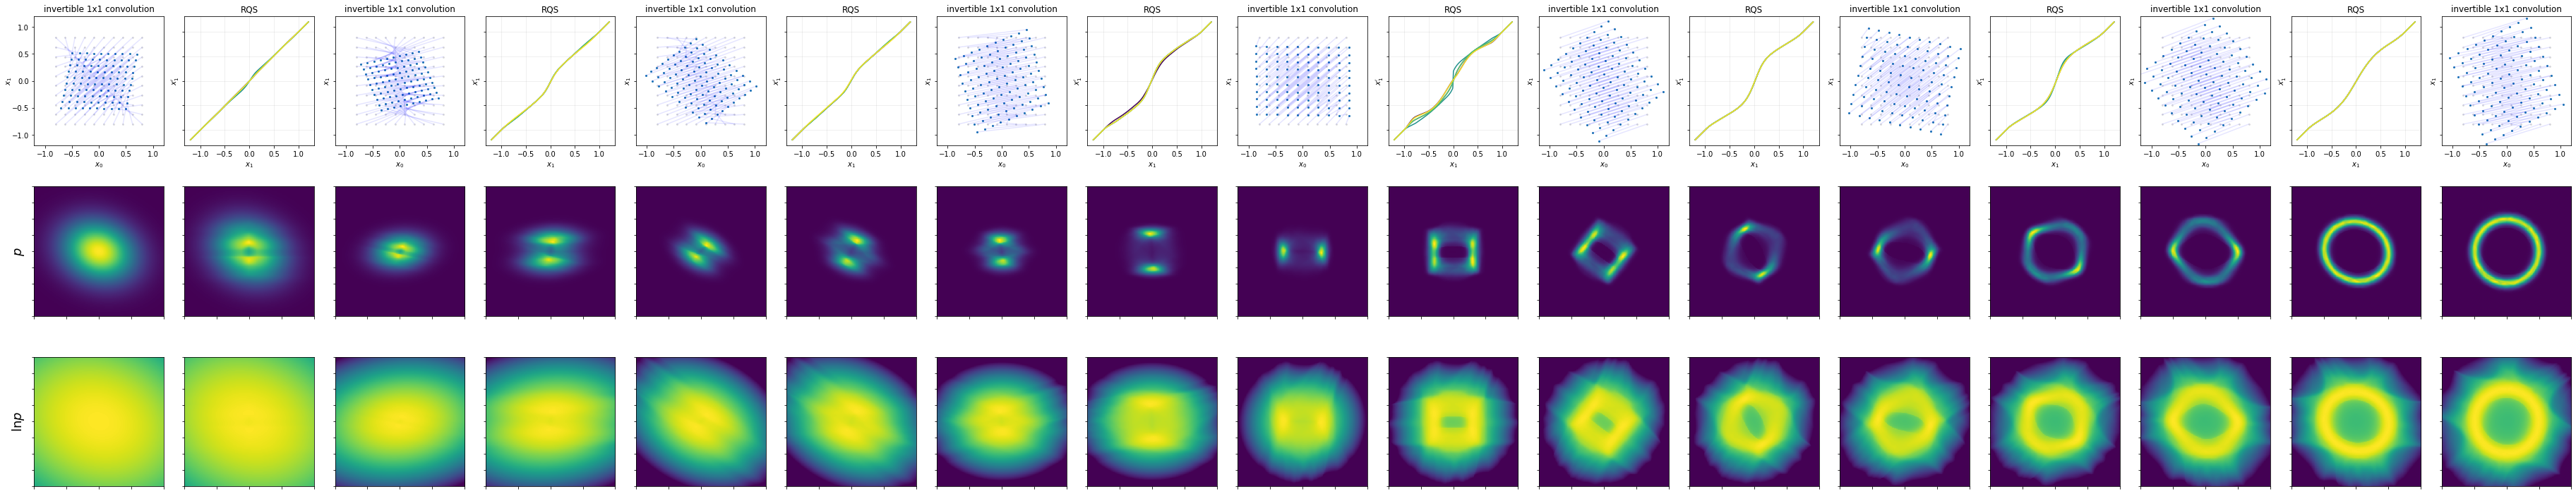

In [11]:
fig = flow_tf.plot_bijections(flow)

Finally, we can turn the images of the normalizing flow that were generated during training into a video:

In [14]:
!ffmpeg -y -r 10 -pattern_type glob -i 'nvp_*.png' -c:v libx264 -vf fps=10 -pix_fmt yuv420p flow_training.mp4

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena